## Classification

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from collections import defaultdict
import random
from gensim.models import Word2Vec
from textblob import TextBlob
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import FunctionTransformer
import warnings
warnings.filterwarnings('ignore')


In [2]:
# load and print the data
train_data = pd.read_csv('Data/Classification_ data/train.csv')
test_data = pd.read_csv('Data/Classification_ data/test.csv')
train_data.head(10)

,text,Class
0,each day of my life is different. <repeat>ther...,1
1,<user> sending good thoughts your way. been th...,1
2,<user> sending solidarity & positive thoughts ...,0
3,<user> plan b episode had me tearing up. jane ...,0
4,b'you pretty much have to give your ovaries aw...,0
5,"b""<user> <user> <user> <user> <user> and my fe...",0
6,b'long term effects of <hashtag> breastcancer ...,1
7,(cw: cancer)\n\nand i agree! for people who ca...,0
8,i seriously hope shes ok <number> weeks ago my...,0
9,b' / / i'll be getting my biopsy result on t...,1


In [27]:
# data preprocessing
def preprocess_text(text):
    
    if isinstance(text, str):  # Check if the input is a string
        # Step 1: Convert text to lowercase
        text_lower = text.lower()

        # Step 2: Remove punctuation
        text_no_punct = ''.join([char for char in text_lower if char not in string.punctuation])

        # Step 3: Tokenize the lowercased text
        tokens = word_tokenize(text_no_punct)

        # Step 4: Remove stop words
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [word for word in tokens if word not in stop_words]

        # Step 5: Perform stemming
        stemmer = PorterStemmer()
        stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
        
        # Combine stemmed tokens back into a string
        preprocessed_text = ' '.join(stemmed_tokens)
        
        return preprocessed_text
    
    else: return text

# As the data is already pre-processed, I skip applying the pre-processed function
train_set_processed = train_data.copy()
test_set_processed = test_data.copy()

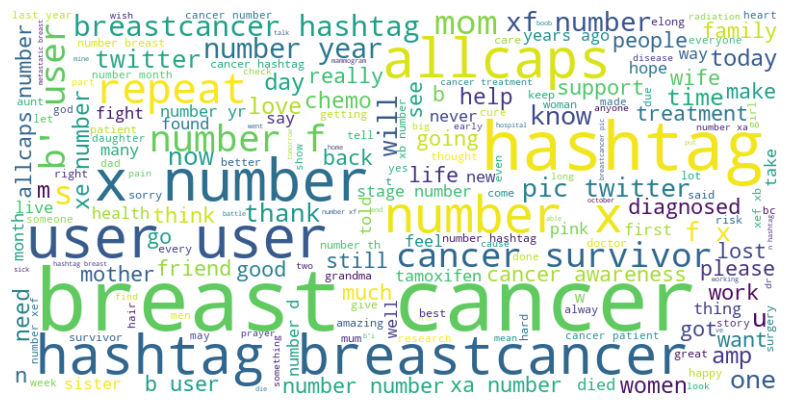

In [6]:
# set a random seed
random.seed(5)
# Concatenate preprocessed text into one string
all_train_preprocessed_text = ' '.join(train_set_processed['text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_train_preprocessed_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [28]:
# label - data split
train_label = train_set_processed['Class']
test_label = test_set_processed['Class']

train_set_text = train_set_processed['text']
test_set_text = test_set_processed['text']

## Different feature extraction techniques

In [29]:
# n-gram 1-3 feature extraction
vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=1000)
train_set_vectorized = vectorizer.fit_transform(train_set_text)
test_set_vectorized = vectorizer.transform(test_set_text)

In [30]:
# apply word cluster technique
word_clusters = {}

def loadwordclusters():
    infile = open('./50mpaths2')
    for line in infile:
        items = str.strip(line).split()
        class_ = items[0]
        term = items[1]
        word_clusters[term] = class_
    return word_clusters

def getclusterfeatures(sent):
    terms = nltk.word_tokenize(sent)
    cluster_string = ''
    for t in terms:
        if t in word_clusters.keys():
                cluster_string += 'clust_' + word_clusters[t] + '_clust '
    return str.strip(cluster_string)

word_clusters = loadwordclusters()

test_clusters = []
training_clusters = []

for tr in train_set_text:
    training_clusters.append(getclusterfeatures(tr))
for tt in test_set_text:
    test_clusters.append(getclusterfeatures(tt))

clustervectorizer = CountVectorizer(ngram_range=(1,3), max_features=1000)

training_cluster_vectors = clustervectorizer.fit_transform(training_clusters).toarray()
test_cluster_vectors = clustervectorizer.transform(test_clusters).toarray()

In [31]:
# generate Word2Vec vectors for sentences
def sentence_vector(sentence, model):
    vectors = []
    for word in sentence:
        try:
            vectors.append(model.wv[word])
        except KeyError:
            continue
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)


tokenized_w2v_train = [sentence.split() for sentence in train_set_text]
tokenized_w2v_test = [sentence.split() for sentence in test_set_text]

model_w2v = Word2Vec(tokenized_w2v_train, vector_size=100, window=5, min_count=1, sg=0)

X_train_w2v = np.array([sentence_vector(sentence, model_w2v) for sentence in tokenized_w2v_train])
X_test_w2v = np.array([sentence_vector(sentence, model_w2v) for sentence in tokenized_w2v_test])

In [32]:
# extract the lenght of texts as a feature set
def text_length(texts):
    return np.array([len(text) for text in texts]).reshape(-1, 1)

X_train_length = text_length(train_set_text)
X_test_length = text_length(test_set_text)

In [33]:
# Tf IDF as a feature set

vectorizer2 = TfidfVectorizer(ngram_range=(1, 3), max_features=1000)
train_set_vectorized2 = vectorizer2.fit_transform(train_set_text)
test_set_vectorized2 = vectorizer2.transform(test_set_text)

In [34]:
# extract LDA as a feature set
from sklearn.decomposition import LatentDirichletAllocation

n_topics_lda = 2 # number of topics
lda = LatentDirichletAllocation(n_components=n_topics_lda, random_state=42)
lda_train = lda.fit_transform(train_set_vectorized2)
lda_test = lda.transform(test_set_vectorized2)

In [35]:
# sentiment score as a feature set
def extract_sentiment_scores(sentences):
    sentiment_scores = []
    for sentence in sentences:
        blob = TextBlob(sentence)
        sentiment_scores.append([blob.polarity, blob.subjectivity])
    return np.array(sentiment_scores)

X_train_sentiment = extract_sentiment_scores(train_set_text)
X_test_sentiment = extract_sentiment_scores(test_set_text)

In [ ]:
# BERT feature extractor
from transformers import BertTokenizer, BertModel
import torch

# Initialize BERT model and tokenizer
bert_model = BertModel.from_pretrained('bert-base-cased')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Function to get BERT embeddings
def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, padding=True, truncation=True, max_length=100, return_tensors="pt")
    outputs = bert_model(**inputs)
    # Use the BERT representation of the `[CLS]` token as sentence embedding
    sentence_embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()
    return sentence_embedding

# extract features
bert_train = np.array([get_bert_embedding(text) for text in train_set_text]).squeeze()
bert_test = np.array([get_bert_embedding(text) for text in test_set_text]).squeeze()

# save the extracted features
np.save('bert_train.npy', bert_train)
np.save('bert_test.npy', bert_test)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


: 

In [12]:
# load the BERT extracted feature set
bert_train = np.load('bert_train.npy')
bert_test = np.load('bert_test.npy')

In [36]:
# concatinate all the feature sets
train_set = np.hstack((train_set_vectorized.toarray(),train_set_vectorized2.toarray(),training_cluster_vectors,X_train_length, X_train_sentiment,X_train_w2v,lda_train, bert_train))
test_set = np.hstack((test_set_vectorized.toarray(),test_set_vectorized2.toarray(),test_cluster_vectors,X_test_length,X_test_sentiment,X_test_w2v,lda_test, bert_test))

In [37]:
# initialize classifiers
classifiers = {
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'Neural Network': MLPClassifier()
}

# train classifiers and print evaluation metrics
for name, clf in classifiers.items():
    # train classifier
    clf.fit(train_set, train_label)
    
    # make predictions
    y_pred = clf.predict(test_set)
    
    # calculate metrics
    acc = accuracy_score(test_label, y_pred)
    f1_micro = f1_score(test_label, y_pred, average='micro')
    f1_macro = f1_score(test_label, y_pred, average='macro')
    
    # print metrics
    print(f"Classifier: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Micro-averaged F1 score: {f1_micro:.4f}")
    print(f"Macro-averaged F1 score: {f1_macro:.4f}")
    print('-' * 40)

Classifier: Naive Bayes
Accuracy: 0.7517
Micro-averaged F1 score: 0.7517
Macro-averaged F1 score: 0.7220
----------------------------------------
Classifier: SVM
Accuracy: 0.7442
Micro-averaged F1 score: 0.7442
Macro-averaged F1 score: 0.4267
----------------------------------------
Classifier: Logistic Regression
Accuracy: 0.8364
Micro-averaged F1 score: 0.8364
Macro-averaged F1 score: 0.7670
----------------------------------------
Classifier: Random Forest
Accuracy: 0.8314
Micro-averaged F1 score: 0.8314
Macro-averaged F1 score: 0.7259
----------------------------------------
Classifier: XGBoost
Accuracy: 0.8596
Micro-averaged F1 score: 0.8596
Macro-averaged F1 score: 0.8016
----------------------------------------
Classifier: LightGBM
Accuracy: 0.8663
Micro-averaged F1 score: 0.8663
Macro-averaged F1 score: 0.8120
----------------------------------------
Classifier: CatBoost
Accuracy: 0.8638
Micro-averaged F1 score: 0.8638
Macro-averaged F1 score: 0.8011
---------------------------

In [38]:
# define a grid search using 5-fild cross validation on the train set
def search_hyperparam_space(params, classifier, x_train, y_train, x_val, y_val):
    grid = GridSearchCV(estimator=classifier, param_grid=params, refit=True, cv=5, return_train_score=False, scoring='f1_micro')
    grid.fit(x_train, y_train)
    return grid.cv_results_

In [39]:
# initialize k fold
skf = StratifiedKFold(n_splits=5)

classifiers = {
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'Neural Network': MLPClassifier()
}

param_grids = {
    'SVM': {'C': [0.01,0.1, 1, 5, 10, 100], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'random_state': [1]},
    'Logistic Regression': {'C': [0.01,0.1, 1, 5, 10, 100], 'penalty': ['none', 'l2'], 'solver': ['liblinear', 'lbfgs'], 'random_state': [1]},
    'Random Forest': {'n_estimators': [50, 100, 200, 500], 'max_depth': [None, 5, 10, 12, 20], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2, 4], 'random_state': [1]},
    'XGBoost': {'learning_rate': [0.01, 0.1], 'n_estimators': [50, 100, 200, 500], 'max_depth': [3, 5, 10, 12], 'random_state': [1]},
    'LightGBM': {'learning_rate': [0.01, 0.1], 'n_estimators': [50, 100, 200, 500], 'max_depth': [3, 5, 10, 12], 'random_state': [1]},
    'CatBoost': {'learning_rate': [0.01, 0.1], 'iterations': [50, 100, 200], 'depth': [3, 5, 10], 'random_state': [1]},
    'Neural Network': {'hidden_layer_sizes': [(32, 16, 8), (32, 64, 16), (64, 128, 32)], 'random_state': [1]}
}


for name, param_grid in param_grids.items():
    all_results = []
    for train_index, valid_index in skf.split(train_set, train_label):

        train_set_ = train_set[train_index]
        valid_set_ = train_set[valid_index]
    
        y_train_, y_valid_ = train_label[train_index], train_label[valid_index]
    
        cv_results = search_hyperparam_space(param_grid, classifiers[name], train_set_, y_train_, valid_set_, y_valid_)
        all_results.append(cv_results)

    # initialize dictionaries to aggregate results.
    param_sums = defaultdict(float)
    param_counts = defaultdict(int)

    # aggregate the results across all folds.
    for fold_result in all_results:
        means = fold_result['mean_test_score']
        params = fold_result['params']
        for mean, param in zip(means, params):
            param_str = str(param)
            param_sums[param_str] += mean
            param_counts[param_str] += 1

    # compute the average f1_micro score for each parameter setting.
    param_avgs = {param: total_sum / param_counts[param] for param, total_sum in param_sums.items()}

    # find the parameter setting with the highest average f1_micro score.
    best_param = max(param_avgs, key=param_avgs.get)
    print(f"Best parameter setting across all folds for {classifiers[name]}: {best_param}")
    print('-' * 40)

Best parameter setting across all folds for MLPClassifier(): {'hidden_layer_sizes': (32, 16, 8), 'random_state': 1}
----------------------------------------


In [40]:
# run the fine-tuned classifiers
classifiers = {
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(C = 5, kernel = 'linear', random_state = 1),
    'Logistic Regression': LogisticRegression(solver = 'liblinear', random_state = 1),
    'Random Forest': RandomForestClassifier(max_depth = 10, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 1),
    'XGBoost': XGBClassifier(learning_rate = 0.1, max_depth = 12, n_estimators = 500, random_state = 1),
    'LightGBM': LGBMClassifier(learning_rate = 0.01, max_depth = 3, n_estimators = 200, random_state = 1),
    'CatBoost': CatBoostClassifier(learning_rate = 0.01, iterations = 100 , depth =10, verbose=0, random_state = 1) 
}

# train classifiers and print evaluation metrics
for name, clf in classifiers.items():
    # train classifier
    clf.fit(train_set, train_label)
    
    # make predictions
    y_pred = clf.predict(test_set)
    
    # calculate metrics
    acc = accuracy_score(test_label, y_pred)
    f1_micro = f1_score(test_label, y_pred, average='micro')
    f1_macro = f1_score(test_label, y_pred, average='macro')
    
    # print metrics
    print(f"Classifier: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Micro-averaged F1 score: {f1_micro:.4f}")
    print(f"Macro-averaged F1 score: {f1_macro:.4f}")
    print('-' * 40)

Classifier: Naive Bayes
Accuracy: 0.6957
Micro-averaged F1 score: 0.6957
Macro-averaged F1 score: 0.6933
----------------------------------------
Classifier: SVM
Accuracy: 0.7101
Micro-averaged F1 score: 0.7101
Macro-averaged F1 score: 0.7096
----------------------------------------
Classifier: Logistic Regression
Accuracy: 0.7246
Micro-averaged F1 score: 0.7246
Macro-averaged F1 score: 0.7237
----------------------------------------
Classifier: Random Forest
Accuracy: 0.7246
Micro-averaged F1 score: 0.7246
Macro-averaged F1 score: 0.7225
----------------------------------------
Classifier: XGBoost
Accuracy: 0.6957
Micro-averaged F1 score: 0.6957
Macro-averaged F1 score: 0.6957
----------------------------------------
Classifier: LightGBM
Accuracy: 0.6377
Micro-averaged F1 score: 0.6377
Macro-averaged F1 score: 0.6349
----------------------------------------
Classifier: CatBoost
Accuracy: 0.6522
Micro-averaged F1 score: 0.6522
Macro-averaged F1 score: 0.6394
---------------------------

In [19]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


# initialize individual models
svm_clf = SVC(C = 5, kernel = 'linear', random_state = 1)
lr_clf = LogisticRegression(solver = 'liblinear', random_state = 1)
rf_clf = RandomForestClassifier(max_depth = 10, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 1)

# create an ensemble of the models using majority class voting
ensemble_clf = VotingClassifier(estimators=[
    ('random_forest', rf_clf),
    ('svm', svm_clf),
    ('logistic_regression', lr_clf)
], voting='hard')  # 'hard' for majority class voting

# fit the ensemble model on the training data
ensemble_clf.fit(train_set , train_label)

# make predictions on the test data
y_pred = ensemble_clf.predict(test_set)

# calculate micro and macro averaged F1 scores
acc = accuracy_score(test_label, y_pred)
f1_micro = f1_score(test_label, y_pred, average='micro')
f1_macro = f1_score(test_label, y_pred, average='macro')
print(f"Accuracy: {acc:.4f}")
print(f"Micro-averaged F1 score: {f1_micro:.4f}")
print(f"Macro-averaged F1 score: {f1_macro:.4f}")

Accuracy: 0.7246
Micro-averaged F1 score: 0.7246
Macro-averaged F1 score: 0.7237


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load GloVe embeddings
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_set_text)
sequences_train = tokenizer.texts_to_sequences(train_set_text)
sequences_test = tokenizer.texts_to_sequences(test_set_text)

# Pad the sequences
max_sequence_length = 100
data_train = pad_sequences(sequences_train, maxlen=max_sequence_length)
data_test = pad_sequences(sequences_test, maxlen=max_sequence_length)

# Prepare embedding matrix
glove_file = 'glove.6B.100d.txt'
word_index = tokenizer.word_index
embeddings_index = load_glove_embeddings(glove_file)
embedding_dim = 100 
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define the model
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=False)) 
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy']) 

# Train the model
model.fit(data_train, train_label, epochs=4) 

# save the model
model.save("trained_bilstm_model.h5")


Epoch 1/4
88/88 [==============================] - 103s 964ms/step - loss: 0.5752 - accuracy: 0.7406 - val_loss: 0.5916 - val_accuracy: 0.7425
Epoch 2/4
88/88 [==============================] - 102s 1s/step - loss: 0.5275 - accuracy: 0.7441 - val_loss: 0.5579 - val_accuracy: 0.7425
Epoch 3/4
88/88 [==============================] - 86s 981ms/step - loss: 0.5145 - accuracy: 0.7445 - val_loss: 0.4709 - val_accuracy: 0.7425
Epoch 4/4
88/88 [==============================] - 95s 1s/step - loss: 0.4571 - accuracy: 0.7808 - val_loss: 0.4638 - val_accuracy: 0.7525


In [24]:
# load the saved model
from tensorflow.keras.models import load_model

loaded_lstm_model = load_model("trained_bilstm_model.h5")

y_pred = loaded_lstm_model.predict(data_test)

print("Accuracy:", accuracy_score(test_label, (y_pred >= 0.5).astype(int)))
print("F1-score:", f1_score(test_label, (y_pred >= 0.5).astype(int)))

38/38 [==============================] - 5s 138ms/step
Accuracy: 0.7624584717607974
F1-score: 0.6266318537859007


In [4]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW


texts_train_BERT = train_data['text'].tolist()
classes_train_BERT = train_data['Class'].tolist()

texts_test_BERT = test_data['text'].tolist()
classes_test_BERT = test_data['Class'].tolist()

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

train_encodings = tokenizer(texts_train_BERT, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(texts_test_BERT, truncation=True, padding=True, max_length=100)

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = TextDataset(train_encodings, classes_train_BERT)
val_dataset = TextDataset(test_encodings, classes_test_BERT)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)

optimizer = AdamW(model.parameters(), lr=5e-5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(1): 
    model.train()
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    predictions, true_labels = [], []
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=-1).tolist())
        true_labels.extend(batch['labels'].tolist())

    val_accuracy = accuracy_score(true_labels, predictions)
    print(f'Epoch {epoch}: Validation Accuracy: {val_accuracy}')



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

KeyboardInterrupt: 

In [ ]:
model.save_pretrained('./BERT_large_model')
tokenizer.save_pretrained('./BERT_large_model')

In [ ]:
model = BertForSequenceClassification.from_pretrained('./BERT_large_model')
tokenizer = BertTokenizer.from_pretrained('./BERT_large_model')

In [ ]:
def predict(text, model, tokenizer):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=100, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    probs = outputs.logits.softmax(dim=-1)
    predicted_class = torch.argmax(probs, dim=-1).item()
    return predicted_class

predicted_class = predict(texts_test_BERT, model, tokenizer)

### Training set size versus performance analysis

In [70]:
acc_a = []
f1_micro_a = []
f1_macro_a = []

for i in np.arange(0.1, 1.1, 0.01):
    len_ = len(train_set_text)*i

    train_set_text2 = train_set_text.copy()
    test_set_text2 = test_set_text.copy()
    train_label2 =train_label.copy()

    train_set_text2 = train_set_text2[:int(len_)]
    train_label2 = train_label[:int(len_)]

    X_train_length = text_length(train_set_text2)
    X_test_length = text_length(test_set_text2)

    vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=1000)
    train_set_vectorized = vectorizer.fit_transform(train_set_text2)
    test_set_vectorized = vectorizer.transform(test_set_text2)

    vectorizer2 = TfidfVectorizer(ngram_range=(1, 3), max_features=1000)
    train_set_vectorized2 = vectorizer2.fit_transform(train_set_text2)
    test_set_vectorized2 = vectorizer2.transform(test_set_text2)

    lda = LatentDirichletAllocation(n_components=n_topics_lda, random_state=42)
    lda_train = lda.fit_transform(train_set_vectorized2)
    lda_test = lda.transform(test_set_vectorized2)

    word_clusters = {}

    word_clusters = loadwordclusters()

    test_clusters = []
    training_clusters = []

    for tr in train_set_text2:
        training_clusters.append(getclusterfeatures(tr))
    for tt in test_set_text2:
        test_clusters.append(getclusterfeatures(tt))

    clustervectorizer = CountVectorizer(ngram_range=(1,3), max_features=1000)

    training_cluster_vectors = clustervectorizer.fit_transform(training_clusters).toarray()
    test_cluster_vectors = clustervectorizer.transform(test_clusters).toarray()



    X_train_sentiment = extract_sentiment_scores(train_set_text2)
    X_test_sentiment = extract_sentiment_scores(test_set_text2)

    tokenized_w2v_train = [sentence.split() for sentence in train_set_text2]
    tokenized_w2v_test = [sentence.split() for sentence in test_set_text2]

    model_w2v = Word2Vec(tokenized_w2v_train, vector_size=100, window=5, min_count=1, sg=0)

    X_train_w2v = np.array([sentence_vector(sentence, model_w2v) for sentence in tokenized_w2v_train])
    X_test_w2v = np.array([sentence_vector(sentence, model_w2v) for sentence in tokenized_w2v_test])

    train_set2 = np.hstack((train_set_vectorized.toarray(),train_set_vectorized2.toarray(),training_cluster_vectors,X_train_length, lda_train, X_train_sentiment,X_train_w2v)) #
    test_set2 = np.hstack((test_set_vectorized.toarray(),test_set_vectorized2.toarray(),test_cluster_vectors,X_test_length,lda_test, X_test_sentiment,X_test_w2v)) #


    clf = RandomForestClassifier(max_depth = 10, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 1)


    # train classifier
    clf.fit(train_set2, train_label2)
    
    # make predictions
    y_pred = clf.predict(test_set2)
    
    # calculate metrics
    acc = accuracy_score(test_label, y_pred)
    f1_micro = f1_score(test_label, y_pred, average='micro')
    f1_macro = f1_score(test_label, y_pred, average='macro')

    acc_a.append(acc)
    f1_micro_a.append(f1_micro)
    f1_macro_a.append(f1_macro)

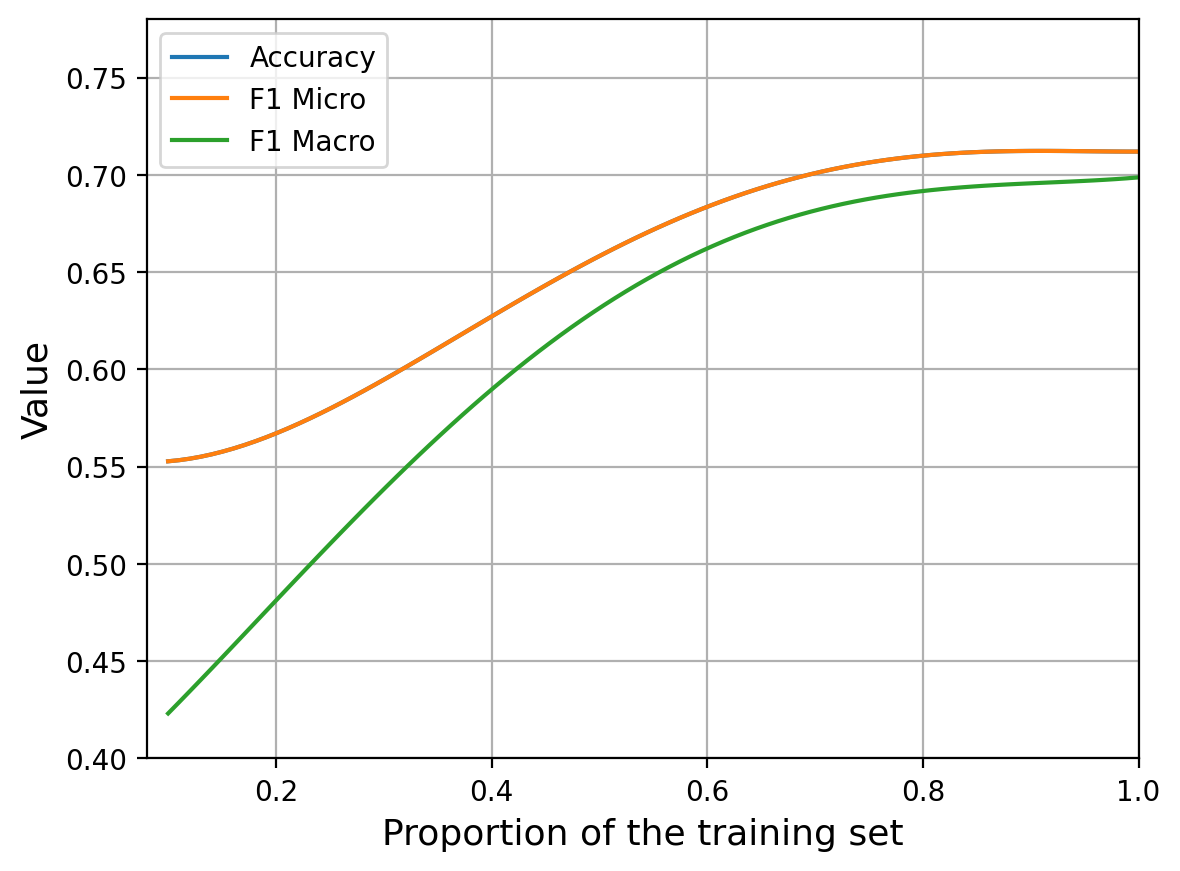

In [82]:
import matplotlib.pyplot as plt
# original x-values
x = np.arange(0.1, 1.1, 0.01)

# polynomial fitting
degree = 4  # Degree of the polynomial 
coefficients_acc = np.polyfit(x, acc_a, degree)
polynomial_acc = np.poly1d(coefficients_acc)

coefficients_mi = np.polyfit(x, f1_micro_a, degree)
polynomial_mi = np.poly1d(coefficients_mi)

coefficients_ma = np.polyfit(x, f1_macro_a, degree)
polynomial_ma = np.poly1d(coefficients_ma)

# generate new x values for plotting the smooth curve
x_new = np.linspace(0.1, 1.1, 100)
y_acc = polynomial_acc(x_new)
y_mi = polynomial_mi(x_new)
y_ma = polynomial_ma(x_new)

plt.figure(dpi = 200)
# plotting
plt.plot(x_new, y_acc, '-', label='Accuracy', )
plt.plot(x_new, y_mi, '-', label='F1 Micro')
plt.plot(x_new, y_ma, '-', label='F1 Macro')
plt.xlabel('Proportion of the training set', fontsize = 13)
plt.ylabel('Value', fontsize = 13)
plt.xlim(0.08,1.0)
plt.ylim(0.40,0.78)
plt.legend()
plt.grid(True)
plt.show()